# Load libraries and set device up

In [2]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [3]:
n_epochs      = 300
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.9
test_ratio    = 0.05  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'EPA'
folder = 'MP-EPA-deep'

target_folder = f'models/{folder}'

# Generate or load graph database for training

In [5]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name'    f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':  f'{target_folder}/uncertainty_data.json',
    'model_name'         f'{target_folder}/model.pt'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

In [18]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/MP_dataset',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

    # Defining target factor
    target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

Number of training   graphs: 40500
Number of validation graphs: 2250
Number of testing    graphs: 2250


Define data loaders.

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [25]:
model = clm.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [29]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=model_name)

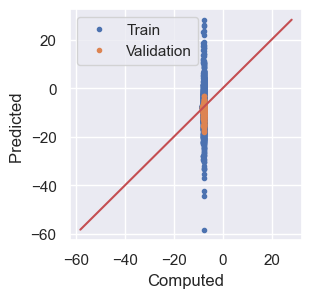

Epoch: 1, Train MAE: 1.8962, Val MAE: 1.1564
Epoch: 2, Train MAE: 0.4005, Val MAE: 1.4053
Epoch: 3, Train MAE: 0.2439, Val MAE: 1.4039
Epoch: 4, Train MAE: 0.1914, Val MAE: 1.3922
Epoch: 5, Train MAE: 0.1512, Val MAE: 1.4907


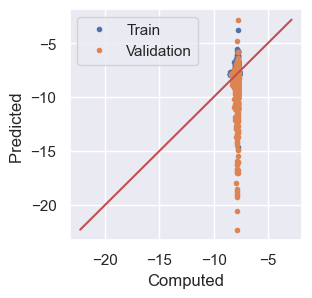

Epoch: 6, Train MAE: 0.1381, Val MAE: 1.4138
Epoch: 7, Train MAE: 0.1353, Val MAE: 1.6516
Epoch: 8, Train MAE: 0.1642, Val MAE: 1.8902
Epoch: 9, Train MAE: 0.1080, Val MAE: 1.7946
Epoch: 10, Train MAE: 0.1230, Val MAE: 1.7618


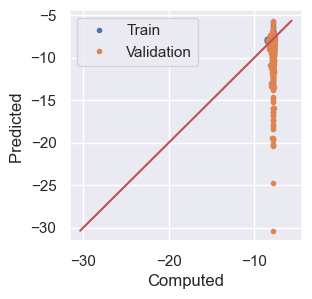

Epoch: 11, Train MAE: 0.0864, Val MAE: 1.6191
Epoch: 12, Train MAE: 0.0904, Val MAE: 1.5684
Epoch: 13, Train MAE: 0.0859, Val MAE: 1.2301
Epoch: 14, Train MAE: 0.0965, Val MAE: 1.5014
Epoch: 15, Train MAE: 0.0777, Val MAE: 1.5763


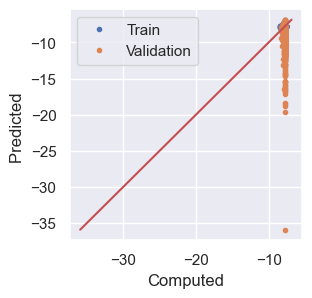

Epoch: 16, Train MAE: 0.0711, Val MAE: 1.5500
Epoch: 17, Train MAE: 0.0700, Val MAE: 1.4969
Epoch: 18, Train MAE: 0.0756, Val MAE: 1.1229
Epoch: 19, Train MAE: 0.0664, Val MAE: 1.1155
Epoch: 20, Train MAE: 0.0627, Val MAE: 1.0977


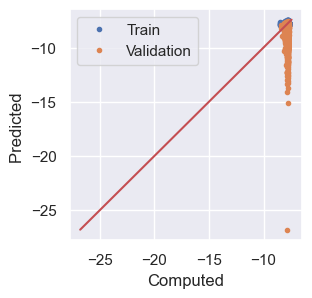

Epoch: 21, Train MAE: 0.0618, Val MAE: 1.0956
Epoch: 22, Train MAE: 0.0602, Val MAE: 1.1189
Epoch: 23, Train MAE: 0.0585, Val MAE: 0.9565
Epoch: 24, Train MAE: 0.0581, Val MAE: 0.9544
Epoch: 25, Train MAE: 0.0572, Val MAE: 0.9239


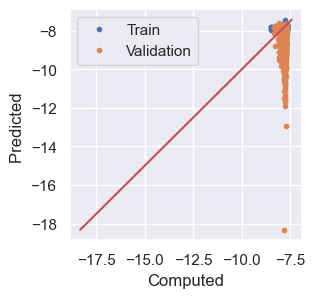

Epoch: 26, Train MAE: 0.0567, Val MAE: 0.7911
Epoch: 27, Train MAE: 0.0563, Val MAE: 0.8062
Epoch: 28, Train MAE: 0.0561, Val MAE: 0.9148
Epoch: 29, Train MAE: 0.0560, Val MAE: 0.7569
Epoch: 30, Train MAE: 0.0560, Val MAE: 1.1647


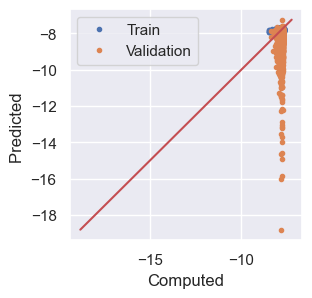

Epoch: 31, Train MAE: 0.0562, Val MAE: 0.9830
Epoch: 32, Train MAE: 0.0558, Val MAE: 1.2740
Epoch: 33, Train MAE: 0.0563, Val MAE: 1.0465
Epoch: 34, Train MAE: 0.0563, Val MAE: 1.1114
Epoch: 35, Train MAE: 0.0557, Val MAE: 1.3352


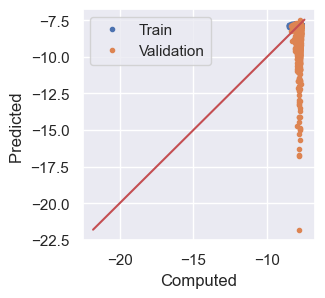

Epoch: 36, Train MAE: 0.0561, Val MAE: 1.1256
Epoch: 37, Train MAE: 0.0585, Val MAE: 1.6745
Epoch: 38, Train MAE: 0.0572, Val MAE: 1.8704
Epoch: 39, Train MAE: 0.0559, Val MAE: 1.8072
Epoch: 40, Train MAE: 0.0557, Val MAE: 2.0447


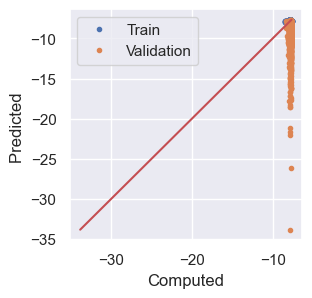

Epoch: 41, Train MAE: 0.0557, Val MAE: 2.0649
Epoch: 42, Train MAE: 0.0554, Val MAE: 2.3806
Epoch: 43, Train MAE: 0.0556, Val MAE: 3.1965
Epoch: 44, Train MAE: 0.0551, Val MAE: 2.8550
Epoch: 45, Train MAE: 0.0550, Val MAE: 2.5785


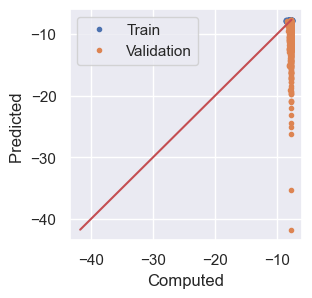

Epoch: 46, Train MAE: 0.0551, Val MAE: 2.6940
Epoch: 47, Train MAE: 0.0547, Val MAE: 2.6559
Epoch: 48, Train MAE: 0.0546, Val MAE: 3.2196
Epoch: 49, Train MAE: 0.0545, Val MAE: 3.4679
Epoch: 50, Train MAE: 0.0545, Val MAE: 3.6435


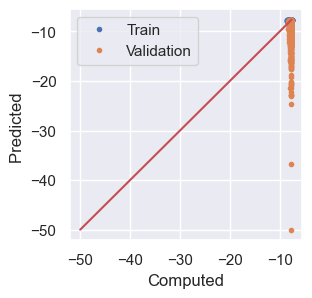

Epoch: 51, Train MAE: 0.0542, Val MAE: 2.7219
Epoch: 52, Train MAE: 0.0541, Val MAE: 3.7053
Epoch: 53, Train MAE: 0.0543, Val MAE: 3.4968
Epoch: 54, Train MAE: 0.0542, Val MAE: 3.9412
Epoch: 55, Train MAE: 0.0667, Val MAE: 3.5144


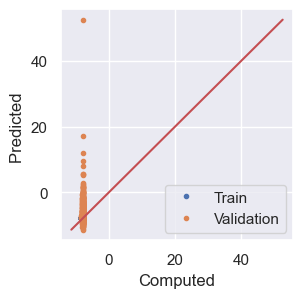

Epoch: 56, Train MAE: 0.0563, Val MAE: 2.3554
Epoch: 57, Train MAE: 0.0547, Val MAE: 1.6004
Epoch: 58, Train MAE: 0.0547, Val MAE: 1.2339
Epoch: 59, Train MAE: 0.0546, Val MAE: 0.7733
Epoch: 60, Train MAE: 0.0546, Val MAE: 0.8369


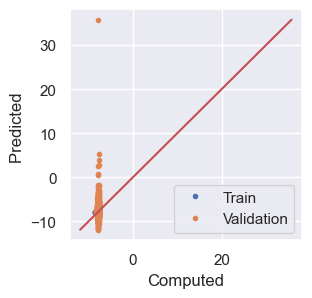

Epoch: 61, Train MAE: 0.0546, Val MAE: 1.4028
Epoch: 62, Train MAE: 0.0545, Val MAE: 1.4571
Epoch: 63, Train MAE: 0.0546, Val MAE: 1.7244
Epoch: 64, Train MAE: 0.0546, Val MAE: 1.3980
Epoch: 65, Train MAE: 0.0545, Val MAE: 1.4772


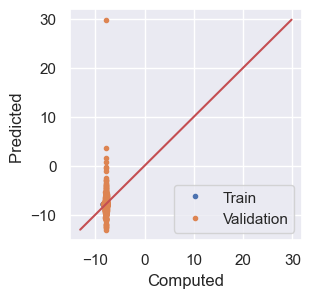

Epoch: 66, Train MAE: 0.0546, Val MAE: 1.2391
Epoch: 67, Train MAE: 0.0545, Val MAE: 1.2631
Epoch: 68, Train MAE: 0.0545, Val MAE: 1.5281
Epoch: 69, Train MAE: 0.0545, Val MAE: 1.6511
Epoch: 70, Train MAE: 0.0546, Val MAE: 1.7545


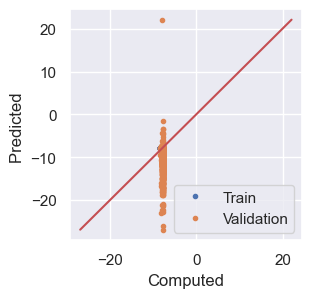

Epoch: 71, Train MAE: 0.0546, Val MAE: 3.0929
Epoch: 72, Train MAE: 0.0544, Val MAE: 2.8641
Epoch: 73, Train MAE: 0.0545, Val MAE: 2.1660
Epoch: 74, Train MAE: 0.0545, Val MAE: 2.9486
Epoch: 75, Train MAE: 0.0543, Val MAE: 3.7117


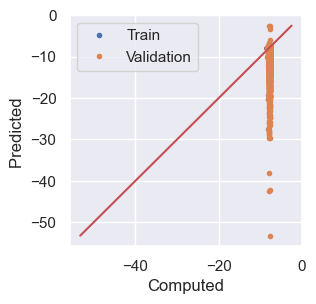

Epoch: 76, Train MAE: 0.0544, Val MAE: 4.5688
Epoch: 77, Train MAE: 0.0545, Val MAE: 6.2750



KeyboardInterrupt



In [30]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

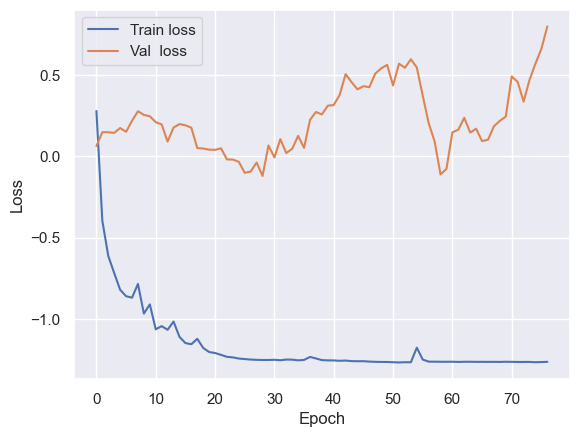

In [31]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [32]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt', map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

GCNN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 32)
  (linconv1): Linear(in_features=32, out_features=32, bias=True)
  (linconv2): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

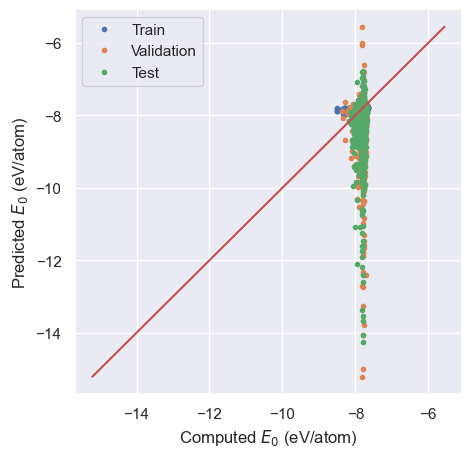

Train MAE: 0.0563, Val MAE: 0.7569, Test MAE: 0.7412


In [33]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor.to(device),
                                                              standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [55]:
train_dataset

[Data(x=[78, 4], edge_index=[2, 2896], edge_attr=[2896], y=[1], name='a', label='Gd2Ti2O7-C2-m'),
 Data(x=[10, 4], edge_index=[2, 76], edge_attr=[76], y=[1], label='LiAs3H2O9-P2_1-c'),
 Data(x=[26, 4], edge_index=[2, 890], edge_attr=[890], y=[1], label='VAg2HgO4-I-42d'),
 Data(x=[12, 4], edge_index=[2, 308], edge_attr=[308], y=[1], label='Y5Be6Fe3(SiO5)6-P1'),
 Data(x=[35, 4], edge_index=[2, 1099], edge_attr=[1099], y=[1], label='CdSO4-Cmcm'),
 Data(x=[82, 4], edge_index=[2, 2596], edge_attr=[2596], y=[1], label='CdSO4-Pmn2_1'),
 Data(x=[18, 4], edge_index=[2, 720], edge_attr=[720], y=[1], label='CdSO4-P3m1'),
 Data(x=[30, 4], edge_index=[2, 950], edge_attr=[950], y=[1], label='CdSO4-C2-m'),
 Data(x=[64, 4], edge_index=[2, 2180], edge_attr=[2180], y=[1], label='Cs2MnNiF6-R3m'),
 Data(x=[7, 4], edge_index=[2, 140], edge_attr=[140], y=[1], label='Cs3Zr7BCl20-R-3c'),
 Data(x=[40, 4], edge_index=[2, 1540], edge_attr=[1540], y=[1], label='Li2Mn2CoO6-P-1'),
 Data(x=[128, 4], edge_index=[2, 1

In [35]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor.to(device),
                                            standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

array([-2.4802208e-02,  6.2897682e-02,  9.8514557e-04, ...,
        1.4989853e-02,  9.2029572e-05, -3.2732964e-02],
      shape=(40500,), dtype=float32)

In [36]:
# Generate dictionary with uncertainty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx in range(dataset):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(files_names['uncertainty_data'], 'w') as json_file:
    json.dump(uncertainty_data, json_file)